In [0]:
## Connecting to the drive

In [2]:

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
## Importing libraries

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.python.framework import ops
import os
from glob import glob
import random
import matplotlib.pylab as plt
import cv2
from scipy.misc import imresize
from scipy.misc import imread
from keras.preprocessing import image
import math
import h5py
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from sklearn.cross_validation import train_test_split



Using TensorFlow backend.


In [0]:
## Finding paths to all images in drive 

In [8]:
images001 = glob(os.path.join("drive/app/sample/sample/images", "*.png"))
print(images001[0:10],"\n")
print(len(images001))

['drive/app/sample/sample/images/00027229_000.png', 'drive/app/sample/sample/images/00021358_000.png', 'drive/app/sample/sample/images/00017515_004.png', 'drive/app/sample/sample/images/00015231_000.png', 'drive/app/sample/sample/images/00003212_000.png', 'drive/app/sample/sample/images/00007500_001.png', 'drive/app/sample/sample/images/00011237_087.png', 'drive/app/sample/sample/images/00017907_000.png', 'drive/app/sample/sample/images/00018821_012.png', 'drive/app/sample/sample/images/00019464_004.png'] 

5607


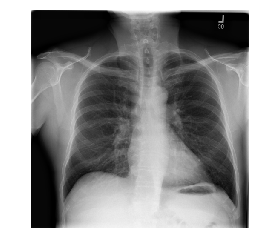

In [36]:
%matplotlib inline
image_name = "drive/app/sample/sample/images/00021358_000.png" #Image to be used as query
def plotImage(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (512,512))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotImage(image_name)

In [0]:
## Labels to all images

In [9]:
labels = pd.read_csv('drive/app/sample/sample_labels.csv')
labels.tail(5)

Image Index                   Finding Labels  Follow-up #  \
5601  00030712_000.png                       No Finding            0   
5602  00030786_005.png  Cardiomegaly|Effusion|Emphysema            5   
5603  00030789_000.png                     Infiltration            0   
5604  00030792_000.png                       No Finding            0   
5605  00030797_000.png                       No Finding            0   

      Patient ID Patient Age Patient Gender View Position  OriginalImageWidth  \
5601       30712        058Y              M            PA                2021   
5602       30786        061Y              F            AP                3056   
5603       30789        052Y              F            PA                2021   
5604       30792        010Y              F            PA                1775   
5605       30797        024Y              M            PA                2021   

      OriginalImageHeight  OriginalImagePixelSpacing_x  \
5601                 2021                     0.194311   
5602                 2544                     0.139000   
5603                 2021                     0.194311   
5604                 1712                     0.194311   
5605                 2021                     0.194311   

      OriginalImagePixelSpacing_y  
5601                     0.194311  
5602                     0.139000  
5603                     0.194311  
5604                     0.194311  
5605                     0.194311

In [0]:
## Preprocessing images -> Resizing & Applying CLAHE

In [0]:
df=pd.DataFrame(labels)
def proc_images3(images):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    NoFinding = "No Finding" #0
    Consolidation="Consolidation" #1
    Infiltration="Infiltration" #2
    Pneumothorax="Pneumothorax" #3
    Edema="Edema" # 7
    Emphysema="Emphysema" #7
    Fibrosis="Fibrosis" #7
    Effusion="Effusion" #4
    Pneumonia="Pneumonia" #7
    Pleural_Thickening="Pleural_Thickening" #7
    Cardiomegaly="Cardiomegaly" #7
    NoduleMass="Nodule" #5
    Hernia="Hernia" #7
    Atelectasis="Atelectasis"  #6 
    RareClass = ["Edema", "Emphysema", "Fibrosis", "Pneumonia", "Pleural_Thickening", "Cardiomegaly","Hernia"]
    x = [] # images as arrays
    y = [] # labels
    WIDTH = 227
    HEIGHT = 227
    for img in images:
        base = os.path.basename(img)
        # Read and resize image
        full_size_image = cv2.imread(img,0)
        finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]
        symbol = "|"
        if symbol in finding:
            continue
        else:
            print(base,end=' ')
            if NoFinding in finding:
                finding = 0
                y.append(finding)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                cl1 = clahe.apply(full_size_image)
                x.append(cv2.resize(cl1, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))      
            elif Consolidation in finding:
                finding = 1
                y.append(finding)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                cl1 = clahe.apply(full_size_image)
                x.append(cv2.resize(cl1, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))      
            elif Infiltration in finding:
                finding = 2
                y.append(finding)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                cl1 = clahe.apply(full_size_image)
                x.append(cv2.resize(cl1, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))      
            elif Pneumothorax in finding:
                finding = 3
                y.append(finding)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                cl1 = clahe.apply(full_size_image)
                x.append(cv2.resize(cl1, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))      
            elif Edema in finding:
                finding = 7
                y.append(finding)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                cl1 = clahe.apply(full_size_image)
                x.append(cv2.resize(cl1, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))      
            elif Emphysema in finding:
                finding = 7
                y.append(finding)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                cl1 = clahe.apply(full_size_image)
                x.append(cv2.resize(cl1, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))      
                finding = 7
                y.append(finding)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                cl1 = clahe.apply(full_size_image)
                x.append(cv2.resize(cl1, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))      
            elif Effusion in finding:
                finding = 4
                y.append(finding)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                cl1 = clahe.apply(full_size_image)
                x.append(cv2.resize(cl1, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))      
            elif Pneumonia in finding:
                finding = 7
                y.append(finding)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                cl1 = clahe.apply(full_size_image)
                x.append(cv2.resize(cl1, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))      
            elif Pleural_Thickening in finding:
                finding = 7
                y.append(finding)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                cl1 = clahe.apply(full_size_image)
                x.append(cv2.resize(cl1, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))      
            elif Cardiomegaly in finding:
                finding = 7
                y.append(finding)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                cl1 = clahe.apply(full_size_image)
                x.append(cv2.resize(cl1, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))      
            elif NoduleMass in finding:
                finding = 5
                y.append(finding)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                cl1 = clahe.apply(full_size_image)
                x.append(cv2.resize(cl1, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))      
            elif Hernia in finding:
                finding = 7
                y.append(finding)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                cl1 = clahe.apply(full_size_image)
                x.append(cv2.resize(cl1, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))      
            elif Atelectasis in finding:
                finding = 6
                y.append(finding)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                cl1 = clahe.apply(full_size_image)
                x.append(cv2.resize(cl1, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))      
            else:
                continue
    return x,y

In [34]:
'''imgdata=images001[4000:5400]
data,label  =proc_images3(imgdata)

print(len(images001))'''

5608


In [0]:
## Importing already processed data

In [0]:
import pickle
with open("drive/app/data2000.txt", "rb") as fp:   # Unpickling
	d2 = pickle.load(fp)
with open("drive/app/data0.txt", "rb") as fp:   # Unpickling
	d1 = pickle.load(fp)
with open("drive/app/data4000.txt", "rb") as fp:   # Unpickling
	d3 = pickle.load(fp)
with open("drive/app/label2000.txt", "rb") as fp:   # Unpickling
	l2 = pickle.load(fp)
with open("drive/app/label0.txt", "rb") as fp:   # Unpickling
	l1 = pickle.load(fp)
with open("drive/app/label4000.txt", "rb") as fp:   # Unpickling
	l3 = pickle.load(fp)
  

In [0]:
## This data to be used for DenseNet

In [0]:
'''import pickle
with open("drive/app/data2000-240.txt", "rb") as fp:   # Unpickling
	d2 = pickle.load(fp)
with open("drive/app/data0-240.txt", "rb") as fp:   # Unpickling
	d1 = pickle.load(fp)
with open("drive/app/data4000-240.txt", "rb") as fp:   # Unpickling
	d3 = pickle.load(fp)
with open("drive/app/label2000-240.txt", "rb") as fp:   # Unpickling
	l2 = pickle.load(fp)
with open("drive/app/label0-240.txt", "rb") as fp:   # Unpickling
	l1 = pickle.load(fp)
with open("drive/app/label4000-240.txt", "rb") as fp:   # Unpickling
	l3 = pickle.load(fp)
  '''

In [0]:
data = d1+d2+d3
label = l1+l2+l3 

In [7]:
print(len(data),len(label))
print(len(d1),len(l1),len(d2),len(l2),len(d3),len(l3))
type(data)

4275 4275
1609 1609 1639 1639 1027 1027


list

In [8]:
print(np.shape(data))

(4275, 227, 227)


In [0]:
## Converting images to arrays

In [9]:
df=pd.DataFrame()
df["images"]=data
df["labels"]=label
y=label
repo=[]
print(len(df), df.images[0].shape)
len(df["labels"])

df['images'][0]
df['images']=np.array(df['images'])
df['labels']=np.array(df['labels'])

X_train=df.images
for i in range(len(df.images)):

    temp_img=X_train[i]

    temp_img=image.img_to_array(temp_img)
    temp_img/=255

    repo.append(temp_img)

#converting train images to array and applying mean subtraction processing

repo=np.array(repo)
X=repo

print(repo.shape)



4275 (227, 227)
(4275, 227, 227, 1)


In [47]:
repo.shape

(4275, 227, 227, 1)

In [0]:
## Separating test and training data

In [0]:
X_train=repo[:3600]

X_test=repo[3600:]
label=np.reshape(label,(4275,1))


In [0]:
## Creating one hot encoded target variable

In [49]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

data=label
values = np.array(data)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
print(integer_encoded)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded.shape)


(4275, 8)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
label=onehot_encoded
Y_train=label[:3600]
Y_test=label[3600:]
print(np.shape(X_train),np.shape(X_test))
print(np.shape(Y_train),np.shape(Y_test))

(3600, 227, 227, 1) (675, 227, 227, 1)
(3600, 8) (675, 8)


In [0]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    n_H0 -- height of an input image
    n_W0 -- width of an input image
    n_C0 -- number of channels of the input
    n_y -- number of output classes
    
    """
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0],name='X')
    Y = tf.placeholder(tf.float32, [None, n_y],name='Y')
    
    return X, Y

In [0]:
def initialize_parameters():
    """
    Initializes weight parameters 
    """
    
    tf.set_random_seed(1)                              # for consistency in results        
 
    W1 = tf.get_variable("W1", [ 11, 11, 1, 96], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [5,5,96,256], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W3 = tf.get_variable("W3", [3,3,256,384], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W4 = tf.get_variable("W4", [3,3,384,384], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W5 = tf.get_variable("W5", [3,3,384,256], initializer=tf.contrib.layers.xavier_initializer(seed=0))
 
    print(W1.shape,W2.shape)
    parameters = {"W1": W1,
                  "W2": W2,
                 "W3": W3,
                  "W4": W4,
                 "W5":W5}
    
    return parameters

In [0]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:

    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    W4 = parameters['W4']
    W5 = parameters['W5']
    
    print("X ",X.shape)

    
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 4, 4, 1], padding='VALID')
    print("Z1 ",Z1.shape)
    # RELU
    A1 = tf.nn.relu(Z1)
    print("A1 ",A1.shape)
    # Dropout for regularization
    A1 = tf.nn.dropout(A1,0.5 )## dropout

    # MAXPOOL
    P1 = tf.nn.max_pool(A1, ksize = [1, 3, 3, 1], strides = [1, 2, 2, 1], padding='VALID')
    
    print("P1 ",P1.shape)

    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    
    print("A2 ",A2.shape)

    # MAXPOOL
    P2 = tf.nn.max_pool(A2, ksize = [1, 3, 3, 1], strides = [1, 2, 2, 1], padding='VALID')
    print("P2 ",P2.shape)
    
    # CONV2D: filters W3, stride 1, padding 'SAME'
    Z3 = tf.nn.conv2d(P2, W3, strides=[1, 1, 1, 1], padding='SAME')
    print("Z3 ",Z3.shape)
    
    # RELU
    A3 = tf.nn.relu(Z3)
    
    print("A3 ",A3.shape)
    # CONV2D: filters W4, stride 1, padding 'SAME'
    Z4 = tf.nn.conv2d(A3, W4, strides=[1, 1, 1, 1], padding='SAME')
    print("Z4 ",Z4.shape)
    
    # RELU
    A4 = tf.nn.relu(Z4)
    
    #CONV2D: filters W5, stride 1, padding 'SAME'
    Z5 = tf.nn.conv2d(A4, W5, strides=[1, 1, 1, 1], padding='SAME')
    print("Z5 ",Z5.shape)
    
    # RELU
    A5 = tf.nn.relu(Z5)
    
    # MAXPOOL
    P3 = tf.nn.max_pool(A5, ksize = [1, 3, 3, 1], strides = [1, 2, 2, 1], padding='VALID')
    
    print("P3 ",P3.shape)
 
    
    # FLATTEN
    P = tf.contrib.layers.flatten(P3)
    print("P ",P.shape)
 
    # 8 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    
    Z3 = tf.contrib.layers.fully_connected(P, 8, activation_fn=None)
    print("Z3 ",Z3.shape)
  
    return Z3

In [0]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    Z3 -- output of forward propagation 
    Y -- "true" labels vector placeholder, same shape as Z3
    """
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))    
    return cost

In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    X -- input data
    Y -- true "label" vector
    mini_batch_size -- size of the mini-batches

    """
    
    np.random.seed(seed)            # To make same "random" minibatches everytime
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size 
    for k in range(0, num_complete_minibatches):

        mini_batch_X = X[k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = Y[k * mini_batch_size:(k + 1) * mini_batch_size]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        end = m - mini_batch_size * math.floor(m / mini_batch_size)
        mini_batch_X = X[num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = Y[num_complete_minibatches * mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [0]:
def AlexNet(X_train, Y_train, X_test, Y_test, learning_rate=0.009,
          num_epochs=100, minibatch_size=64, print_cost=True):
    """
    Implements AlexNet in Tensorflow:
    X_train -- training set
    Y_train -- test set
    X_test -- training set
    Y_test -- test set
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
  
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph 
    cost = compute_cost(Z3, Y)
    
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        #saver=tf.train.Saver()

        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost.
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 10 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
                
                
                    
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1,name='y_pred')
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

(11, 11, 1, 96) (5, 5, 96, 256)
X  (?, 227, 227, 1)
Z1  (?, 55, 55, 96)
A1  (?, 55, 55, 96)
P1  (?, 27, 27, 96)
A2  (?, 27, 27, 256)
P2  (?, 13, 13, 256)
Z3  (?, 13, 13, 384)
A3  (?, 13, 13, 384)
Z4  (?, 13, 13, 384)
Z5  (?, 13, 13, 256)
P3  (?, 6, 6, 256)
P  (?, 9216)
Z3  (?, 8)
Cost after epoch 0: 857.317602


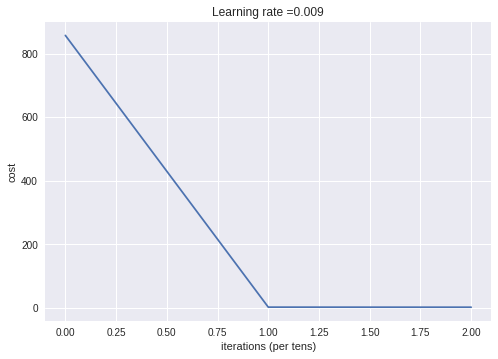

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.6661111
Test Accuracy: 0.6844444


In [63]:
_, _, parameters = AlexNet(X_train, Y_train, X_test, Y_test,num_epochs=3,learning_rate=0.009,minibatch_size=64)

In [23]:
print(label.shape)

(4275, 8)


In [0]:
## DenseNet

In [0]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import cv2
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.mobilenet import MobileNet

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Training Data Shape:", len(X_train), X_train[0].shape)
print("Testing Data Shape:", len(X_test), X_test[0].shape)


Training Data Shape: (2575, 224, 224, 3)
Testing Data Shape: (644, 224, 224, 3)
Training Data Shape: 2575 (224, 224, 3)
Testing Data Shape: 644 (224, 224, 3)


In [0]:
Y_trainHot = to_categorical(Y_train, num_classes = 8)
Y_testHot = to_categorical(Y_test, num_classes = 8)

In [44]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
print(class_weight)

[0.18559732 6.9375     1.11461219 4.84789157 2.775      4.14819588
 2.75599315 2.4992236 ]


In [0]:
dict_characters = {0:'No Finding',1: 'Consolidation', 2: 'Infiltration', 
        3: 'Pneumothorax', 4:'Effusion', 5: 'Nodule Mass', 6: 'Atelectasis', 7: "Other Rare Classes"}


In [0]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save('drive/app/logs.npy', self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('drive/app/logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('drive/app/accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('drive/app/loss_curve.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

conv4_block18_1_bn (BatchNormal (None, 14, 14, 128)  512         conv4_block18_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block18_1_relu (Activatio (None, 14, 14, 128)  0           conv4_block18_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block18_2_conv (Conv2D)   (None, 14, 14, 32)   36864       conv4_block18_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block18_concat (Concatena (None, 14, 14, 832)  0           conv4_block17_concat[0][0]       
                                                                 conv4_block18_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block19_0_bn (BatchNormal (None, 14, 14, 832)  3328        conv4_block18_concat[0][0]       
__________

2575/2575 [==============================] - 38s 15ms/step - loss: 1.7058 - acc: 0.5771 - val_loss: 1.9139 - val_acc: 0.6630
Epoch 2/20
2575/2575 [==============================] - 33s 13ms/step - loss: 0.8214 - acc: 0.7410 - val_loss: 1.8938 - val_acc: 0.6553
Epoch 3/20
2575/2575 [==============================] - 33s 13ms/step - loss: 0.4157 - acc: 0.8610 - val_loss: 1.9884 - val_acc: 0.6537
Epoch 4/20
2575/2575 [==============================] - 33s 13ms/step - loss: 0.2173 - acc: 0.9340 - val_loss: 2.4592 - val_acc: 0.6661
Epoch 5/20
 288/2575 [==>...........................] - ETA: 22s - loss: 0.0905 - acc: 0.9861

2575/2575 [==============================] - 33s 13ms/step - loss: 0.1249 - acc: 0.9635 - val_loss: 2.0428 - val_acc: 0.6304
Epoch 6/20
2575/2575 [==============================] - 33s 13ms/step - loss: 0.0766 - acc: 0.9829 - val_loss: 2.2796 - val_acc: 0.6599
Epoch 7/20
2575/2575 [==============================] - 33s 13ms/step - loss: 0.0564 - acc: 0.9868 - val_loss: 3.1158 - val_acc: 0.6661
Epoch 8/20
2575/2575 [==============================] - 33s 13ms/step - loss: 0.0374 - acc: 0.9938 - val_loss: 2.7496 - val_acc: 0.6491
Epoch 9/20
 320/2575 [==>...........................] - ETA: 21s - loss: 0.0192 - acc: 1.0000

2575/2575 [==============================] - 33s 13ms/step - loss: 0.0269 - acc: 0.9961 - val_loss: 3.0098 - val_acc: 0.6615
Epoch 10/20
2575/2575 [==============================] - 33s 13ms/step - loss: 0.0199 - acc: 0.9984 - val_loss: 3.5387 - val_acc: 0.6661
Epoch 11/20
2575/2575 [==============================] - 33s 13ms/step - loss: 0.0180 - acc: 0.9969 - val_loss: 3.0583 - val_acc: 0.6646
Epoch 12/20
2575/2575 [==============================] - 33s 13ms/step - loss: 0.0124 - acc: 0.9981 - val_loss: 3.4114 - val_acc: 0.6677
Epoch 13/20
 288/2575 [==>...........................] - ETA: 22s - loss: 0.0052 - acc: 1.0000

2575/2575 [==============================] - 33s 13ms/step - loss: 0.0088 - acc: 0.9996 - val_loss: 3.4611 - val_acc: 0.6677
Epoch 14/20
2575/2575 [==============================] - 33s 13ms/step - loss: 0.0083 - acc: 0.9992 - val_loss: 3.6694 - val_acc: 0.6677
Epoch 15/20
2575/2575 [==============================] - 33s 13ms/step - loss: 0.0055 - acc: 1.0000 - val_loss: 3.7404 - val_acc: 0.6661
Epoch 16/20
2575/2575 [==============================] - 33s 13ms/step - loss: 0.0056 - acc: 0.9992 - val_loss: 3.9034 - val_acc: 0.6661
Epoch 17/20
 288/2575 [==>...........................] - ETA: 22s - loss: 0.0035 - acc: 1.0000

2575/2575 [==============================] - 33s 13ms/step - loss: 0.0037 - acc: 1.0000 - val_loss: 3.9691 - val_acc: 0.6661
Epoch 18/20
2575/2575 [==============================] - 33s 13ms/step - loss: 0.0033 - acc: 0.9996 - val_loss: 3.7667 - val_acc: 0.6615
Epoch 19/20
2575/2575 [==============================] - 33s 13ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 3.7210 - val_acc: 0.6553
Epoch 20/20
2575/2575 [==============================] - 33s 13ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 4.2775 - val_acc: 0.6677

Keras CNN #2 - accuracy: 0.6677018633540373 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



                    precision    recall  f1-score   support

        No Finding       0.67      1.00      0.80       431
     Consolidation       0.00      0.00      0.00        12
      Infiltration       0.00      0.00      0.00        87
      Pneumothorax       0.00      0.00      0.00        17
          Effusion       0.00      0.00      0.00        29
       Nodule Mass       0.00      0.00      0.00        18
       Atelectasis       0.00      0.00      0.00        25
Other Rare Classes       0.00      0.00      0.00        25

       avg / total       0.45      0.67      0.54       644



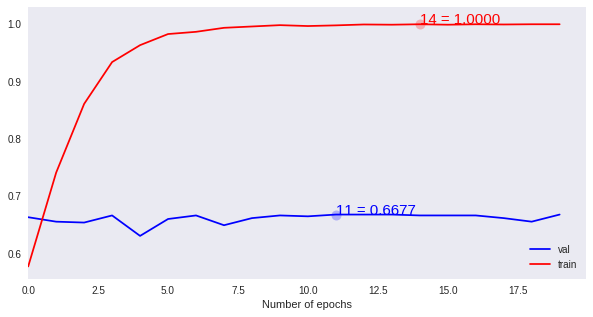

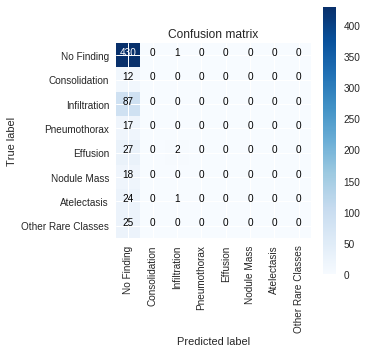

In [47]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
import keras
#weight_path = 'drive/app/densenet121_weights_tf.h5'
im_size = 224
map_characters=dict_characters
def densenetwork(a,b,c,d,e,f,g):
    num_class = f
    epochs = g
    base_model=keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet', input_tensor=None, input_shape=(im_size, im_size,3), pooling=None, classes=8)
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0001), 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    model.fit(a,b, epochs=epochs, class_weight=e, validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('drive/app/logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
    plt.show()
    return model
densenetwork(X_train, Y_trainHot, X_test, Y_testHot,class_weight,8,20)

In [0]:
## Checking GPU Usage

In [45]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()


Gen RAM Free: 5.7 GB  I Proc size: 7.2 GB
GPU RAM Free: 503MB | Used: 10936MB | Util  96% | Total 11439MB


In [44]:
import gc
gc.collect()

25

In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config,)